<a href="https://colab.research.google.com/github/yakshini12/INFOSYS-_INTERNSHIP-OIL_SPILL_DETECTION-/blob/main/oil_spill_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the base path for the project directory in Google Drive
base_path = '/content/drive/mydrive/oil_spill_detection'

Cell 2: Install Required Libraries

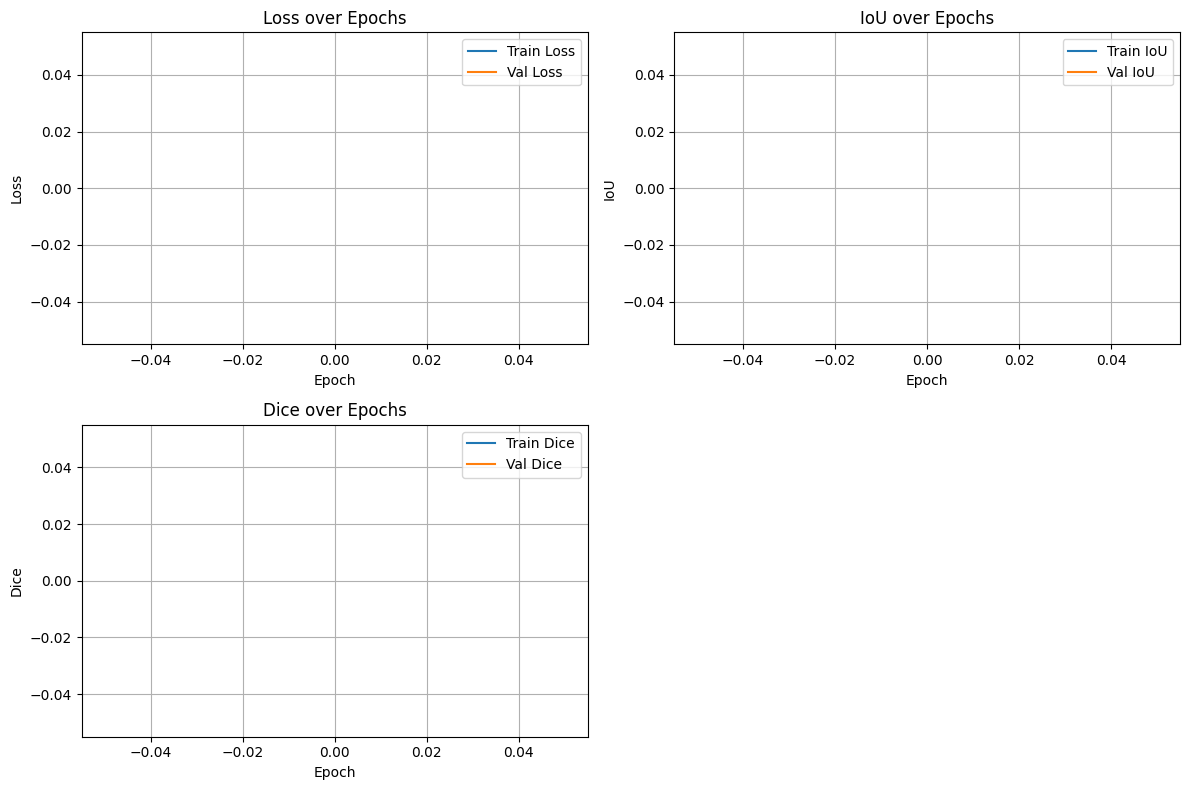

In [ ]:
# Assuming you have lists to store the history like this in your training loop:
# train_losses = []
# val_losses = []
# train_ious = []
# val_ious = []
# train_dices = []
# val_dices = []

# Example plotting code (replace with your actual history lists)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot IoU
plt.subplot(2, 2, 2)
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU')
plt.title('IoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

# Plot Dice
plt.subplot(2, 2, 3)
plt.plot(train_dices, label='Train Dice')
plt.plot(val_dices, label='Val Dice')
plt.title('Dice over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
!pip install segmentation-models-pytorch albumentations -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.6 MB/s eta 0:00:00


Cell 3: Import Libraries and Set Paths


In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from tqdm import tqdm

DATA_ROOT = "/content/drive/MyDrive/oilspilldataset"
TRAIN_IMG = os.path.join(DATA_ROOT, "trainimages")
TRAIN_MASK = os.path.join(DATA_ROOT, "trainmasks")
VAL_IMG = os.path.join(DATA_ROOT, "valimages")
VAL_MASK = os.path.join(DATA_ROOT, "valmasks")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMGSIZE = (256, 256)
BATCH_SIZE = 8


Cell 4: Define Albumentations Augmentations python

In [ ]:
train_aug = A.Compose([
    A.Resize(IMGSIZE[0], IMGSIZE[1]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.12, scale_limit=0.15, rotate_limit=20, p=0.7),
    A.RandomBrightnessContrast(p=0.4),
    A.OneOf([
        A.GaussianBlur(p=1.0),
        A.MotionBlur(p=1.0),
        A.MedianBlur(blur_limit=3, p=1.0)
    ], p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
val_aug = A.Compose([
    A.Resize(IMGSIZE[0], IMGSIZE[1]),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Cell 5: Dataset Preparation and Loader

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import cv2  # Import cv2

# Base path matching your Google Drive folder name exactly
base_path = '/content/drive/MyDrive/oil_spill_dataset'

# ✅ Correct folder names
TRAIN_IMG = os.path.join(base_path, 'train/images')
TRAIN_MASK = os.path.join(base_path, 'train/masks')
VAL_IMG = os.path.join(base_path, 'val/images')
VAL_MASK = os.path.join(base_path, 'val/masks')

class OilSpillDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transforms=None):
        self.imgs = sorted([os.path.join(img_dir, fname) for fname in os.listdir(img_dir)])
        self.masks = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])
        self.transforms = transforms

        if len(self.imgs) != len(self.masks):
            raise ValueError(f"Number of images ({len(self.imgs)}) and masks ({len(self.masks)}) do not match in {img_dir} and {mask_dir}")

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = cv2.imread(self.imgs[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)
        mask = (mask > 127).astype(np.float32)

        if self.transforms:
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        if mask.ndim == 2:
            mask = mask.unsqueeze(0)
        elif mask.ndim == 3 and mask.shape[-1] == 1:
            mask = mask.permute(2, 0, 1)

        return img, mask

# Ensure train_aug and val_aug are defined earlier
BATCH_SIZE = 8
trainset = OilSpillDataset(TRAIN_IMG, TRAIN_MASK, train_aug)
valset = OilSpillDataset(VAL_IMG, VAL_MASK, val_aug)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


Cell 6: Visualize a Batch with Color Mapping




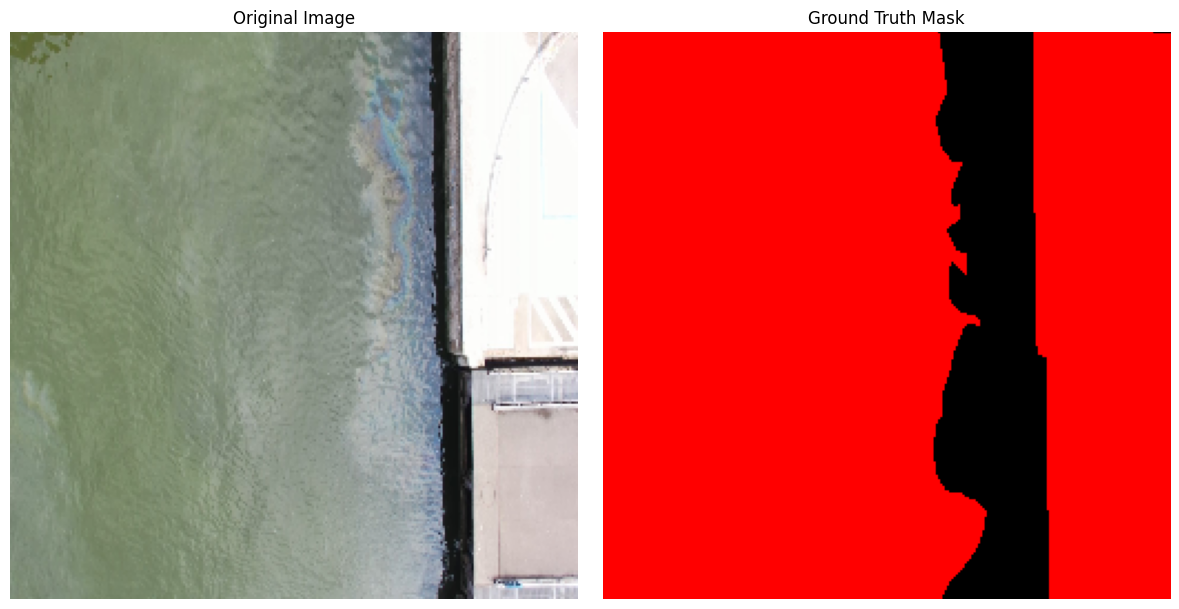

In [ ]:
def color_mask(mask):
    # mask: HxW, 1 or 0
    h, w = mask.shape
    cmask = np.zeros((h, w, 3), dtype=np.uint8)
    cmask[mask==1] = [255, 0, 0] # Oil spill: red
    return cmask

# Get a batch from the validation loader
imgs, masks = next(iter(val_loader))
img = imgs[0].permute(1,2,0).cpu().numpy()
mask = masks[0][0].cpu().numpy()

# De-normalize the image for display
img_display = (img * [0.229,0.224,0.225] + [0.485,0.456,0.406]).clip(0,1)

# Create color masks for visualization
ground_truth_cmask = color_mask(mask)

# Plotting
plt.figure(figsize=(12, 6)) # Adjusted figure size

plt.subplot(1, 2, 1)
plt.imshow(img_display)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ground_truth_cmask)
plt.title("Ground Truth Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

# Note: To see the predicted mask, you need to run the cell where the model is defined first (Cell 7 or similar)
# and then add code to this cell or a new cell to get predictions from the model.

Cell 7: Define Model — UNet (Pretrained, Robust)

In [ ]:
import os
os.environ['HF_HUB_DISABLE_TELEMETRY'] = '1'
import segmentation_models_pytorch as smp

# You can experiment with different architectures available in smpCell 7: Define Model — UNet (Pretrained, Robust)
# Some common options include:
# smp.Unet
# smp.UnetPlusPlus
# smp.DeepLabV3
# smp.DeepLabV3Plus
# smp.FPN
# smp.PAN

# Choose your desired model architecture here
model_architecture = "Unet" # You can change this to try other models

if model_architecture == "Unet":
    model = smp.Unet(
        encoder_name="resnet50",  # You can also experiment with different encoders
        encoder_weights="imagenet", # Use "imagenet" for pretrained weights, or None
        in_channels=3,
        classes=1,
        activation=None # Use None for sigmoid activation with BCEWithLogitsLoss
    ).to(DEVICE)
elif model_architecture == "UnetPlusPlus":
     model = smp.UnetPlusPlus(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None
    ).to(DEVICE)
# Add more elif blocks for other architectures you want to experiment with

print(f"Using model architecture: {model_architecture}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Using model architecture: Unet


Cell 8: Loss, Optimizer, Mixed Precision Setup

In [ ]:
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
import torch.optim as optim # Import optim

bce_loss = nn.BCEWithLogitsLoss()
dice_loss = smp.losses.DiceLoss(mode='binary')
def total_loss(pred, target):
    return 0.5*dice_loss(pred, target) + 0.5*bce_loss(pred, target)

# Experiment with different learning rates and optimizers here
learning_rate = 1e-6 # Changed learning rate to 1e-6
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4) # Switched back to AdamW


# You can also try other optimizers like SGD:
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)


scaler = torch.amp.GradScaler('cuda', enabled=torch.cuda.is_available())

Cell 9: IoU and Dice Metrics

In [ ]:
def iou_score(preds, targets, threshold=0.5, eps=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    preds = preds.view(preds.size(0), -1)
    targets = targets.view(targets.size(0), -1)
    intersection = (preds * targets).sum(1)
    union = preds.sum(1) + targets.sum(1) - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

def dice_coeff(preds, targets, threshold=0.5, eps=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    preds = preds.view(preds.size(0), -1)
    targets = targets.view(targets.size(0), -1)
    intersection = (preds * targets).sum(1)
    dice = (2. * intersection + eps) / (preds.sum(1) + targets.sum(1) + eps)
    return dice.mean().item()


Cell 10: Training & Validation Loops with AMP

In [ ]:
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ---- Metric Functions ----

def pixel_accuracy(preds, targets, threshold=0.5):
    probs = torch.sigmoid(preds)
    preds = (probs > threshold).float()
    targets = targets.float()
    if targets.ndim == 3:
        targets = targets.unsqueeze(1)
    correct = (preds == targets).sum()
    total = targets.numel()
    return (correct.float() / total).item()

def dice_coeff(preds, targets, threshold=0.5, eps=1e-7):
    probs = torch.sigmoid(preds)
    preds = (probs > threshold).float()
    targets = targets.float()
    if targets.ndim == 3:
        targets = targets.unsqueeze(1)
    inter = (preds * targets).sum(dim=(1,2,3))
    denom = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2 * inter + eps) / (denom + eps)
    return dice.mean().item()

def iou_score(preds, targets, threshold=0.5, eps=1e-7):
    probs = torch.sigmoid(preds)
    preds = (probs > threshold).float()
    targets = targets.float()
    if targets.ndim == 3:
        targets = targets.unsqueeze(1)
    inter = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) - inter
    iou = (inter + eps) / (union + eps)
    return iou.mean().item()

# ---- Loss Function ----

bce_loss = torch.nn.BCEWithLogitsLoss()
dice_loss = smp.losses.DiceLoss(mode='binary')
def total_loss(pred, target):
    return 0.7 * bce_loss(pred, target) + 0.3 * dice_loss(pred, target)

# ---- Threshold Sweep ----

def find_best_threshold(model, val_loader, device, candidates=[0.3, 0.4, 0.5, 0.6, 0.7]):
    model.eval()
    scores = {}
    with torch.no_grad():
        for t in candidates:
            acc, n = 0.0, 0
            for imgs, masks in val_loader:
                imgs = imgs.to(device, non_blocking=True)
                masks = masks.to(device, non_blocking=True)
                # Shape fix
                if masks.ndim == 3:
                    masks = masks.unsqueeze(1)
                with autocast(enabled=torch.cuda.is_available()):
                    logits = model(imgs)
                    if logits.shape[-2:] != masks.shape[-2:]:
                        logits = F.interpolate(logits, size=masks.shape[-2:], mode='bilinear', align_corners=False)
                acc += pixel_accuracy(logits, masks, threshold=t) * imgs.size(0)
                n += imgs.size(0)
            scores[t] = acc / n
    best_t = max(scores, key=scores.get)
    print(f"[Optimal threshold sweep] Best threshold: {best_t}, Val accuracy: {scores[best_t]:.4f}")
    return best_t

# ---- Main Training Loop ----

EPOCHS = 25
best_dice = 0.0
early_stopping_patience = 15
epochs_no_improve = 0
best_thr = 0.5

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
train_accuracies, val_accuracies = [], []

model.to(DEVICE)
scaler = GradScaler(enabled=torch.cuda.is_available())
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=8)

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = train_iou = train_dice = train_acc = 0.0
    num_train_samples = 0
    for imgs, masks in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
        imgs = imgs.to(DEVICE, non_blocking=True)
        masks = masks.to(DEVICE, non_blocking=True)
        # Shape correction
        if masks.ndim == 3:
            masks = masks.unsqueeze(1)
        elif masks.ndim == 4 and masks.shape[-1] == 1:
            masks = masks.permute(0, 3, 1, 2)
        elif masks.ndim == 4 and masks.shape[1] == 1:
            pass
        else:
            raise ValueError(f"Unexpected mask shape: {masks.shape}")

        optimizer.zero_grad()
        with autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            if logits.shape[-2:] != masks.shape[-2:]:
                logits = F.interpolate(logits, size=masks.shape[-2:], mode='bilinear', align_corners=False)
            loss = total_loss(logits, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_size = imgs.size(0)
        train_loss += loss.item() * batch_size
        train_iou  += iou_score(logits, masks, threshold=best_thr) * batch_size
        train_dice += dice_coeff(logits, masks, threshold=best_thr) * batch_size
        train_acc  += pixel_accuracy(logits, masks, threshold=best_thr) * batch_size
        num_train_samples += batch_size

    train_loss /= num_train_samples
    train_iou  /= num_train_samples
    train_dice /= num_train_samples
    train_acc  /= num_train_samples
    train_losses.append(train_loss)
    train_ious.append(train_iou)
    train_dices.append(train_dice)
    train_accuracies.append(train_acc)

    # --- Validation ---
    model.eval()
    val_loss = val_iou = val_dice = val_acc = 0.0
    num_val_samples = 0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc="Val"):
            imgs = imgs.to(DEVICE, non_blocking=True)
            masks = masks.to(DEVICE, non_blocking=True)
            if masks.ndim == 3:
                masks = masks.unsqueeze(1)
            elif masks.ndim == 4 and masks.shape[-1] == 1:
                masks = masks.permute(0, 3, 1, 2)
            elif masks.ndim == 4 and masks.shape[1] == 1:
                pass
            else:
                raise ValueError(f"Unexpected mask shape: {masks.shape}")
            with autocast(enabled=torch.cuda.is_available()):
                logits = model(imgs)
                if logits.shape[-2:] != masks.shape[-2:]:
                    logits = F.interpolate(logits, size=masks.shape[-2:], mode='bilinear', align_corners=False)
                loss = total_loss(logits, masks)
            batch_size = imgs.size(0)
            val_loss += loss.item() * batch_size
            val_iou  += iou_score(logits, masks, threshold=best_thr) * batch_size
            val_dice += dice_coeff(logits, masks, threshold=best_thr) * batch_size
            val_acc  += pixel_accuracy(logits, masks, threshold=best_thr) * batch_size
            num_val_samples += batch_size

    val_loss /= num_val_samples
    val_iou  /= num_val_samples
    val_dice /= num_val_samples
    val_acc  /= num_val_samples
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    val_dices.append(val_dice)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Train Dice: {train_dice:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}, Val Acc: {val_acc:.4f}")

    # --- Threshold sweep (every 5 epochs) ---
    if epoch % 5 == 0:
        best_thr = find_best_threshold(model, val_loader, DEVICE)

    # --- Scheduler step & early stopping ---
    scheduler.step(val_dice)
    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f"Early stopping after {early_stopping_patience} epochs without improvement.")
            break


/tmp/ipython-input-3130452030.py:86: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
Train Epoch 1:   0%|          | 0/102 [00:00<?, ?it/s]/tmp/ipython-input-3130452030.py:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
Val:   0%|          | 0/26 [00:00<?, ?it/s]/tmp/ipython-input-3130452030.py:149: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
Val: 100%|██████████| 26/26 [00:10<00:00,  2.52it/s]


Epoch 1, Train Loss: 0.5531, Train IoU: 0.4170, Train Dice: 0.5657, Train Acc: 0.6523, Val Loss: 0.5253, Val IoU: 0.4909, Val Dice: 0.6318, Val Acc: 0.6848
Saved best model


Val: 100%|██████████| 26/26 [00:10<00:00,  2.53it/s]


Epoch 2, Train Loss: 0.5329, Train IoU: 0.4540, Train Dice: 0.5993, Train Acc: 0.6778, Val Loss: 0.5031, Val IoU: 0.5241, Val Dice: 0.6586, Val Acc: 0.7131
Saved best model


Val: 100%|██████████| 26/26 [00:10<00:00,  2.59it/s]


Epoch 3, Train Loss: 0.5144, Train IoU: 0.4853, Train Dice: 0.6259, Train Acc: 0.6996, Val Loss: 0.4805, Val IoU: 0.5527, Val Dice: 0.6807, Val Acc: 0.7399
Saved best model


Val: 100%|██████████| 26/26 [00:09<00:00,  2.74it/s]


Epoch 4, Train Loss: 0.4991, Train IoU: 0.5136, Train Dice: 0.6505, Train Acc: 0.7187, Val Loss: 0.4666, Val IoU: 0.5921, Val Dice: 0.7113, Val Acc: 0.7646
Saved best model


Val: 100%|██████████| 26/26 [00:09<00:00,  2.72it/s]

Epoch 5, Train Loss: 0.4844, Train IoU: 0.5403, Train Dice: 0.6717, Train Acc: 0.7379, Val Loss: 0.4498, Val IoU: 0.6128, Val Dice: 0.7268, Val Acc: 0.7830



/tmp/ipython-input-3130452030.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[Optimal threshold sweep] Best threshold: 0.4, Val accuracy: 0.8180
Saved best model


Val: 100%|██████████| 26/26 [00:10<00:00,  2.49it/s]


Epoch 6, Train Loss: 0.4699, Train IoU: 0.6558, Train Dice: 0.7564, Train Acc: 0.7967, Val Loss: 0.4356, Val IoU: 0.6933, Val Dice: 0.7791, Val Acc: 0.8214
Saved best model


Val: 100%|██████████| 26/26 [00:09<00:00,  2.64it/s]


Epoch 7, Train Loss: 0.4626, Train IoU: 0.6629, Train Dice: 0.7603, Train Acc: 0.8003, Val Loss: 0.4313, Val IoU: 0.7016, Val Dice: 0.7840, Val Acc: 0.8285
Saved best model


Val: 100%|██████████| 26/26 [00:09<00:00,  2.85it/s]


Epoch 8, Train Loss: 0.4506, Train IoU: 0.6713, Train Dice: 0.7658, Train Acc: 0.8116, Val Loss: 0.4154, Val IoU: 0.7125, Val Dice: 0.7913, Val Acc: 0.8397
Saved best model


Val: 100%|██████████| 26/26 [00:09<00:00,  2.70it/s]


Epoch 9, Train Loss: 0.4408, Train IoU: 0.6809, Train Dice: 0.7738, Train Acc: 0.8174, Val Loss: 0.4069, Val IoU: 0.7169, Val Dice: 0.7944, Val Acc: 0.8407
Saved best model


Val: 100%|██████████| 26/26 [00:10<00:00,  2.46it/s]

Epoch 10, Train Loss: 0.4325, Train IoU: 0.6862, Train Dice: 0.7764, Train Acc: 0.8209, Val Loss: 0.3992, Val IoU: 0.7153, Val Dice: 0.7924, Val Acc: 0.8344


[Optimal threshold sweep] Best threshold: 0.5, Val accuracy: 0.8411


Val: 100%|██████████| 26/26 [00:09<00:00,  2.86it/s]


Epoch 11, Train Loss: 0.4238, Train IoU: 0.6378, Train Dice: 0.7436, Train Acc: 0.8064, Val Loss: 0.3822, Val IoU: 0.7054, Val Dice: 0.7902, Val Acc: 0.8563


Val: 100%|██████████| 26/26 [00:09<00:00,  2.81it/s]


Epoch 12, Train Loss: 0.4154, Train IoU: 0.6489, Train Dice: 0.7519, Train Acc: 0.8120, Val Loss: 0.3755, Val IoU: 0.7192, Val Dice: 0.7992, Val Acc: 0.8621
Saved best model


Val: 100%|██████████| 26/26 [00:09<00:00,  2.66it/s]


Epoch 13, Train Loss: 0.4052, Train IoU: 0.6624, Train Dice: 0.7611, Train Acc: 0.8226, Val Loss: 0.3653, Val IoU: 0.7264, Val Dice: 0.8043, Val Acc: 0.8696
Saved best model


Val: 100%|██████████| 26/26 [00:10<00:00,  2.47it/s]


Epoch 14, Train Loss: 0.3979, Train IoU: 0.6693, Train Dice: 0.7651, Train Acc: 0.8300, Val Loss: 0.3636, Val IoU: 0.7302, Val Dice: 0.8064, Val Acc: 0.8712
Saved best model


Val: 100%|██████████| 26/26 [00:10<00:00,  2.46it/s]

Epoch 15, Train Loss: 0.3905, Train IoU: 0.6824, Train Dice: 0.7753, Train Acc: 0.8379, Val Loss: 0.3557, Val IoU: 0.7363, Val Dice: 0.8103, Val Acc: 0.8753


[Optimal threshold sweep] Best threshold: 0.5, Val accuracy: 0.8753
Saved best model


Val: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]


Epoch 16, Train Loss: 0.3885, Train IoU: 0.6846, Train Dice: 0.7762, Train Acc: 0.8382, Val Loss: 0.3521, Val IoU: 0.7417, Val Dice: 0.8135, Val Acc: 0.8772
Saved best model


Val: 100%|██████████| 26/26 [00:10<00:00,  2.45it/s]


Epoch 17, Train Loss: 0.3782, Train IoU: 0.6977, Train Dice: 0.7863, Train Acc: 0.8475, Val Loss: 0.3381, Val IoU: 0.7470, Val Dice: 0.8173, Val Acc: 0.8858
Saved best model


Val: 100%|██████████| 26/26 [00:10<00:00,  2.49it/s]


Epoch 18, Train Loss: 0.3707, Train IoU: 0.6985, Train Dice: 0.7863, Train Acc: 0.8496, Val Loss: 0.3352, Val IoU: 0.7543, Val Dice: 0.8224, Val Acc: 0.8883
Saved best model


Val: 100%|██████████| 26/26 [00:09<00:00,  2.63it/s]


Epoch 19, Train Loss: 0.3676, Train IoU: 0.7047, Train Dice: 0.7908, Train Acc: 0.8508, Val Loss: 0.3345, Val IoU: 0.7556, Val Dice: 0.8228, Val Acc: 0.8840
Saved best model


Val: 100%|██████████| 26/26 [00:09<00:00,  2.72it/s]

Epoch 20, Train Loss: 0.3626, Train IoU: 0.7074, Train Dice: 0.7918, Train Acc: 0.8537, Val Loss: 0.3222, Val IoU: 0.7620, Val Dice: 0.8273, Val Acc: 0.8938


[Optimal threshold sweep] Best threshold: 0.5, Val accuracy: 0.8938
Saved best model


Val: 100%|██████████| 26/26 [00:09<00:00,  2.77it/s]


Epoch 21, Train Loss: 0.3527, Train IoU: 0.7174, Train Dice: 0.7984, Train Acc: 0.8616, Val Loss: 0.3153, Val IoU: 0.7701, Val Dice: 0.8337, Val Acc: 0.9005
Saved best model


Val: 100%|██████████| 26/26 [00:09<00:00,  2.74it/s]


Epoch 22, Train Loss: 0.3458, Train IoU: 0.7231, Train Dice: 0.8018, Train Acc: 0.8674, Val Loss: 0.3125, Val IoU: 0.7726, Val Dice: 0.8348, Val Acc: 0.9036
Saved best model


Val: 100%|██████████| 26/26 [00:10<00:00,  2.47it/s]


Epoch 23, Train Loss: 0.3457, Train IoU: 0.7239, Train Dice: 0.8027, Train Acc: 0.8648, Val Loss: 0.3045, Val IoU: 0.7711, Val Dice: 0.8336, Val Acc: 0.8966


Val: 100%|██████████| 26/26 [00:10<00:00,  2.45it/s]


Epoch 24, Train Loss: 0.3431, Train IoU: 0.7240, Train Dice: 0.8029, Train Acc: 0.8649, Val Loss: 0.2957, Val IoU: 0.7792, Val Dice: 0.8388, Val Acc: 0.9067
Saved best model


Val: 100%|██████████| 26/26 [00:10<00:00,  2.49it/s]

Epoch 25, Train Loss: 0.3358, Train IoU: 0.7320, Train Dice: 0.8083, Train Acc: 0.8715, Val Loss: 0.2927, Val IoU: 0.7857, Val Dice: 0.8442, Val Acc: 0.9104


[Optimal threshold sweep] Best threshold: 0.5, Val accuracy: 0.9104
Saved best model


In [ ]:
!pip install segmentation-models-pytorch -q

In [ ]:
!streamlit run app.py

/bin/bash: line 1: streamlit: command not found


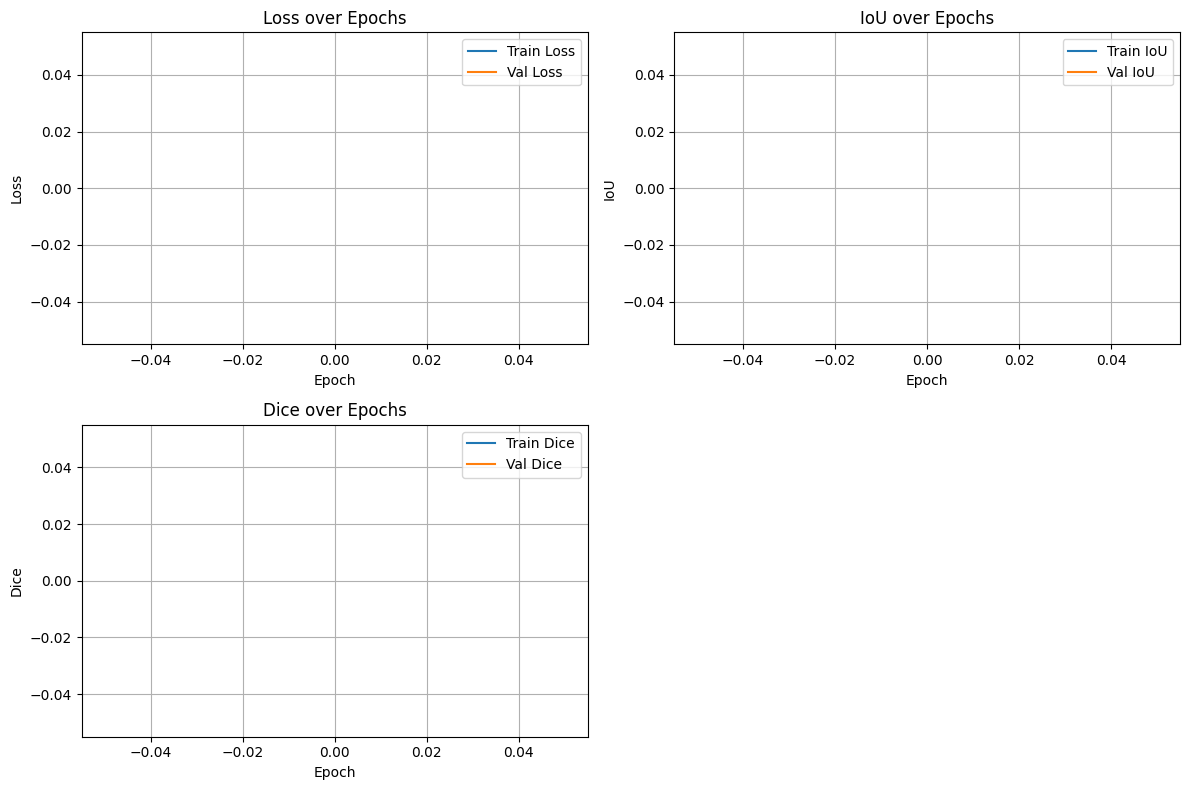

In [ ]:
# Assuming you have lists to store the history like this in your training loop:
# train_losses = []
# val_losses = []
# train_ious = []
# val_ious = []
# train_dices = []
# val_dices = []

# Example plotting code (replace with your actual history lists)

plt.figure(figsize=(12, 8))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot IoU
plt.subplot(2, 2, 2)
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU')
plt.title('IoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

# Plot Dice
plt.subplot(2, 2, 3)
plt.plot(train_dices, label='Train Dice')
plt.plot(val_dices, label='Val Dice')
plt.title('Dice over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

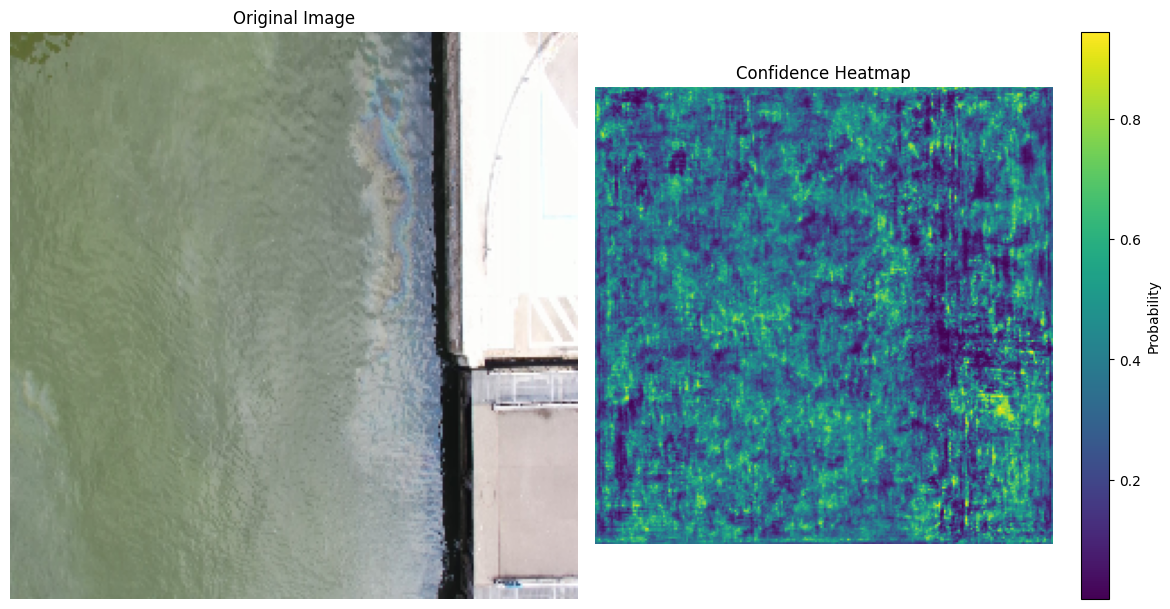

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming the model and DEVICE are already defined
# Load the best model (if not already loaded)
# model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
# model.eval() # Set model to evaluation mode

# Assuming val_loader is defined and accessible
# Get a batch from the validation loader
imgs, masks = next(iter(val_loader))

# Select the first image from the batch
img = imgs[0]

# Move image to device and add batch dimension for prediction
img_tensor = img.unsqueeze(0).to(DEVICE)

# Get raw logits from the model
with torch.no_grad():
    logits = model(img_tensor)
    # Apply sigmoid to get probabilities
    probability_map = torch.sigmoid(logits).squeeze().cpu().numpy()

# De-normalize the image for display if it was normalized during preprocessing
# Assuming normalization mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
img_display = img.permute(1, 2, 0).cpu().numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_display = std * img_display + mean
img_display = np.clip(img_display, 0, 1)


# Plotting the original image and the confidence heatmap
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_display)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(probability_map, cmap='viridis') # Using 'viridis' colormap for heatmap
plt.title("Confidence Heatmap")
plt.colorbar(label="Probability")
plt.axis("off")

plt.tight_layout()
plt.show()

In [58]:
# Save the content of the current cell to a file named app.py
%%writefile app.py
import streamlit as st
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import cv2
import os # Import os for path joining

# Define DEVICE and model architecture (must match training)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMGSIZE = (256, 256) # Must match the size used during training

# Define the path to the saved model (ensure this path is correct)
# Assuming the model was saved in the same directory as the notebook
model_path = "best_model.pth"

# Check if the model file exists
if not os.path.exists(model_path):
    st.error(f"Model file not found at: {model_path}. Please ensure 'best_model.pth' is in the correct location.")
else:
    # Load the trained model
    model = smp.Unet(
        encoder_name="resnet50",
        encoder_weights=None, # No imagenet weights needed for inference
        in_channels=3,
        classes=1,
        activation=None
    ).to(DEVICE)

    # Load the state dict. Ensure the path is correct.
    try:
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        model.eval() # Set model to evaluation mode
    except Exception as e:
        st.error(f"Error loading model state dictionary: {e}")
        model = None # Set model to None if loading fails


# Function to predict mask
def predict_mask(image, model, device, img_size):
    if model is None:
        return None # Return None if model failed to load

    # Preprocess the image
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR) # Convert PIL to OpenCV BGR
    image = cv2.resize(image, img_size) # Resize
    image = image / 255.0 # Normalize to [0, 1]

    # Apply the same normalization as training
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image - mean) / std

    image = np.transpose(image, (2, 0, 1)) # Change to CxHxW
    image = torch.from_numpy(image).float().unsqueeze(0).to(device) # To tensor and add batch dim

    with torch.no_grad():
        logits = model(image)
        pred_mask = torch.sigmoid(logits).squeeze().cpu().numpy() # Apply sigmoid and remove batch/channel dims

    # Apply a threshold (can be adjusted)
    threshold = 0.5
    binary_mask = (pred_mask > threshold).astype(np.uint8)

    return binary_mask

# Function to color the mask
def color_mask(mask):
    # mask: HxW, 1 or 0
    h, w = mask.shape
    cmask = np.zeros((h, w, 3), dtype=np.uint8)
    # Color oil spill area red
    cmask[mask==1] = [255, 0, 0]
    return cmask

# Streamlit app
st.title("Oil Spill Detection")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image.", use_column_width=True)

    if st.button("Predict Oil Spill"):
        if 'model' in locals() and model is not None:
            with st.spinner('Predicting...'):
                pred_mask = predict_mask(image, model, DEVICE, IMGSIZE)

            if pred_mask is not None:
                # Calculate predicted oil spill area (number of oil spill pixels)
                oil_spill_pixels = np.sum(pred_mask)
                total_pixels = pred_mask.size
                oil_spill_percentage = (oil_spill_pixels / total_pixels) * 100 if total_pixels > 0 else 0

                # Convert the predicted mask to a color mask for visualization
                colored_pred_mask = color_mask(pred_mask)

                # Display the predicted mask
                st.subheader("Predicted Oil Spill Mask")
                st.image(colored_pred_mask, caption="Predicted Mask.", use_column_width=True)

                # Provide information in separate alert messages
                st.subheader("Prediction Summary")
                st.info(f"Predicted oil spill area: Approximately {oil_spill_pixels} pixels ({oil_spill_percentage:.2f}% of the image).")

                if oil_spill_percentage > 10: # Example threshold for significant spill
                    st.warning("This indicates a significant potential oil spill. Immediate action and further investigation are recommended.")
                elif oil_spill_percentage > 1: # Example threshold for minor spill
                    st.info("This suggests a possible minor oil spill. Monitoring and further assessment are advised.")
                else:
                    st.success("This indicates a low probability of a significant oil spill in this area. Continued vigilance is always a good practice.")

            else:
                st.error("Prediction failed due to model loading issues.")
        else:
            st.error("Model not loaded. Please check the model file path and try again.")

Overwriting app.py


In [ ]:
!pip install pyngrok -q

In [ ]:
!pip install streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 39.6 MB/s eta 0:00:00


In [59]:
!streamlit run app.py &>/dev/null&

from pyngrok import ngrok
import os
from google.colab import userdata

# Use the GOOGLE_API_KEY secret for ngrok authentication
# Make sure you have added NGROK_AUTH_TOKEN to the Colab secrets
# panel (under the 🔑 icon)
try:
    ngrok_auth_token = userdata.get('NGROK_AUTH_TOKEN')
    ngrok.set_auth_token(ngrok_auth_token)

    # Establish a tunnel to the Streamlit port 8501
    public_url = ngrok.connect('8501') # Modified to pass port as the first argument

    print(f"Streamlit app available at: {public_url}")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please make sure you have added your NGROK_AUTH_TOKEN to the Colab secrets panel (under the 🔑 icon).")

Streamlit app available at: NgrokTunnel: "https://preorganic-revolutionarily-marcell.ngrok-free.dev" -> "http://localhost:8501"
